In [13]:
import pandas as pd
import numpy as np
import scipy.io as sio
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
# plt.style.use(['dark_background', 'bmh'])
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rc('figure', figsize= (8, 5), dpi=200)

### **Step 1: Import rawdata**

In [14]:
df_rawdata = pd.read_csv('./Z24.csv', usecols = [1, 2, 3, 4, 5, 6, 7])
df_rawdata['datetime'] = pd.to_datetime(df_rawdata['datetime'])
df_rawdata.set_index('datetime', inplace=True)
df_rawdata

,f1,f2,f3,f4,Temp,label
datetime,,,,,,
1997-11-11 14:00:00,3.987027,5.194140,10.017850,10.812540,7.465,0.0
1997-11-11 15:00:00,4.050453,5.156154,10.214089,10.806404,7.795,0.0
1997-11-11 16:00:00,3.991237,5.166507,10.347106,10.839854,8.130,0.0
1997-11-11 17:00:00,3.990014,5.152177,10.217715,10.840735,8.290,0.0
1997-11-11 19:00:00,4.005077,5.177117,10.029935,10.771591,7.890,0.0
...,...,...,...,...,...,...
1998-09-11 08:00:00,3.824709,4.722723,9.717825,10.322502,21.155,1.0
1998-09-11 09:00:00,3.832897,4.707808,9.756794,10.431894,20.985,1.0
1998-09-11 11:00:00,3.851463,4.674012,9.696455,10.198018,20.970,1.0


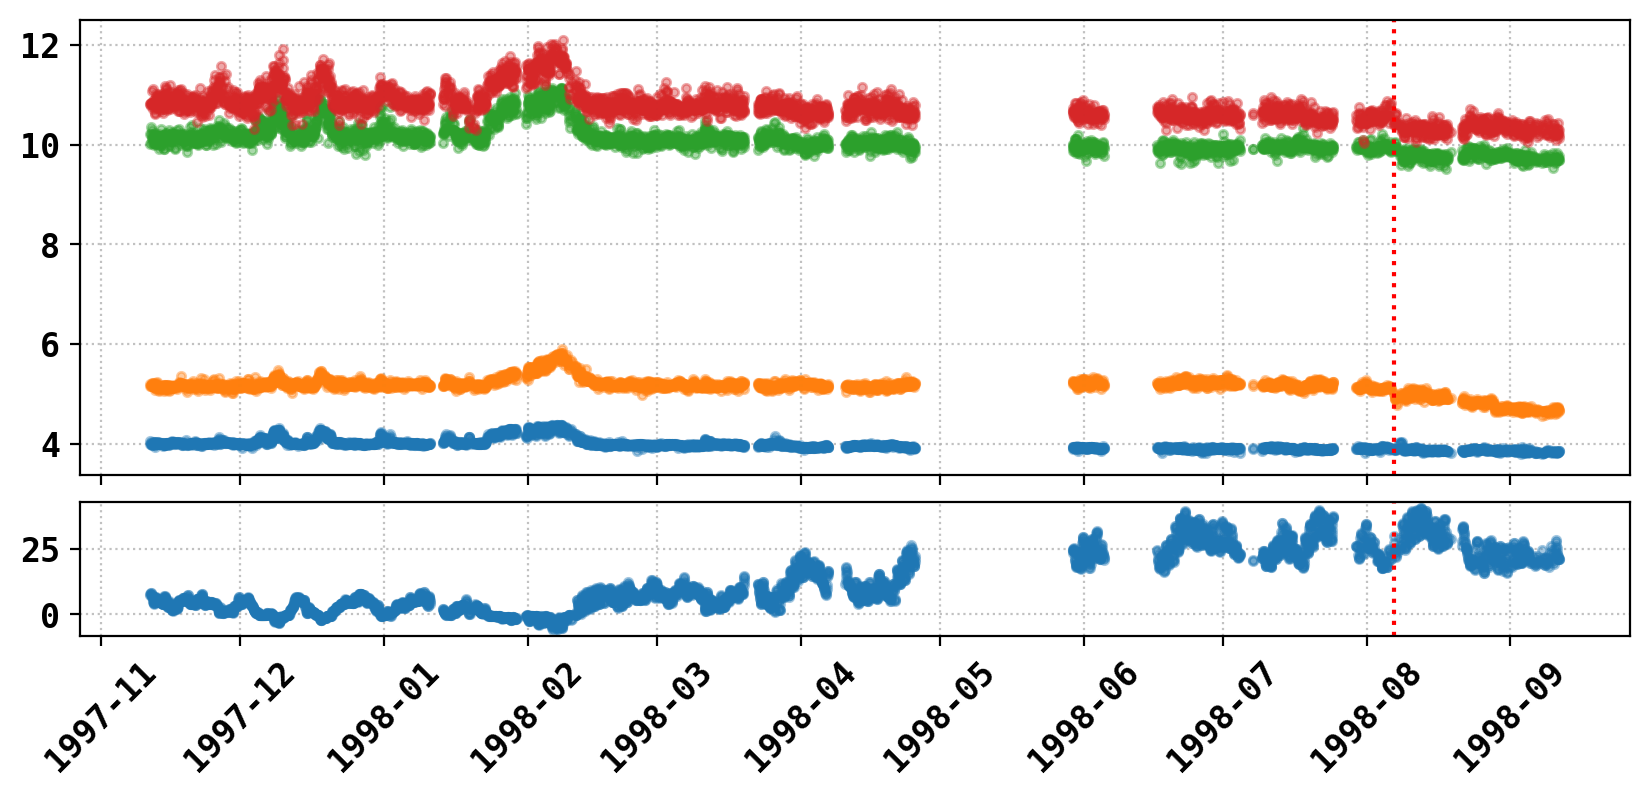

In [15]:
damage_date = np.argwhere(df_rawdata['label'].values == 1)[0]

mosaic = [
    ["A0", "A0", "A0"],
    ["A0", "A0", "A0"],
    ["A0", "A0", "A0"],
    ["A1", "A1", "A1"],
]

fig, axes = plt.subplot_mosaic(mosaic, figsize = (10, 4), dpi = 200, sharex=True)

for col_ in ['f1', 'f2', 'f3', 'f4','Temp']:
    if col_ == 'Temp':
        axes['A1'].plot(df_rawdata.index, df_rawdata[col_], '.', alpha = .4)
    else:
        axes['A0'].plot(df_rawdata.index, df_rawdata[col_], '.', alpha = .4)

axes['A0'].axvline(x = df_rawdata.index[damage_date], color = 'r', linestyle = ':')
axes['A0'].grid(linestyle = ':', alpha = 0.78)
axes['A1'].axvline(x = df_rawdata.index[damage_date], color = 'r', linestyle = ':')
axes['A1'].tick_params(axis='x', labelrotation=45) 
axes['A1'].grid(linestyle = ':', alpha = 0.78)
plt.show()

### **Step 2: Define Initial Traning dataset**
> **최초 초기학습 데이터 구간 정의**

In [16]:
# Datetime 기준 인덱스 찾아주는 코드
def find_date(df_raw, yy, mon, day):
    for i in range(0,len(df_raw.index)):
        if df_raw.index[i].year == yy:
            if df_raw.index[i].month == mon: 
                if df_raw.index[i].day == day:
                    X = i
                    break
                else:
                    continue
    return X

In [17]:
train_ratio = 0.25 # set 25% of normal data as initial training data
# train_ratio = 0.50 # set 50% of normal data as initial training data
# train_ratio = 0.75 # set 75% of normal data as initial training data
bool_normal = (df_rawdata['label'] == 0)
bool_normal

# Training 부분 만들기 (index1 ~ index 2)
ind_train = int(df_rawdata[bool_normal].shape[0] * train_ratio)
ind_train

868

In [18]:
# Define initial training dataset
Xtrain, Ytrain = \
        df_rawdata[['f1', 'f2', 'f3', 'f4']].iloc[:ind_train], \
        df_rawdata['label'].iloc[:ind_train]

# Define validation dataset (not damaged)
Xvalid, Yvalid = \
        df_rawdata[['f1', 'f2', 'f3', 'f4']].iloc[ind_train:df_rawdata[bool_normal].shape[0]], \
        df_rawdata['label'].iloc[ind_train:df_rawdata[bool_normal].shape[0]]

# Define test dataset (damaged)
Xtest, Ytest = \
        df_rawdata[['f1', 'f2', 'f3', 'f4']].iloc[df_rawdata[bool_normal].shape[0]:], \
        df_rawdata['label'].iloc[df_rawdata[bool_normal].shape[0]:]

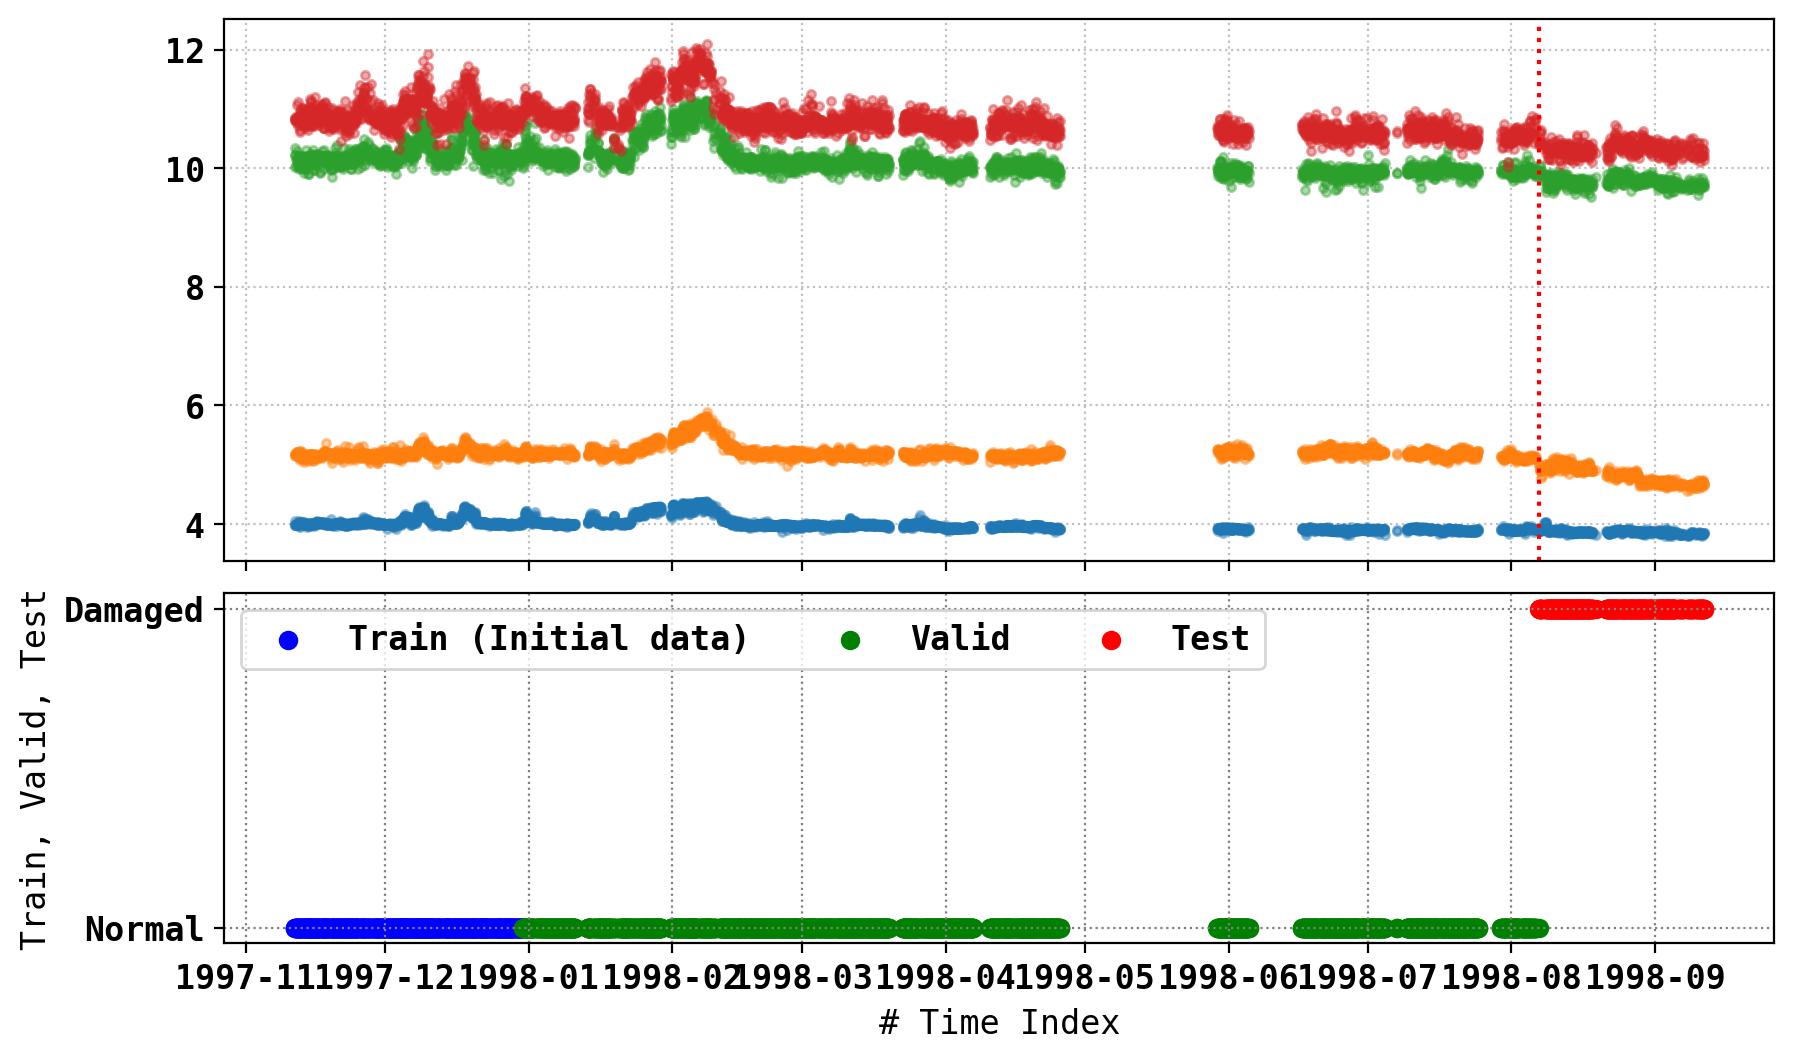

In [19]:
mosaic = [
    ["A0", "A0", "A0"],
    ["A0", "A0", "A0"],
    ["A0", "A0", "A0"],
    ["A1", "A1", "A1"],
    ["A1", "A1", "A1"],
]

fig, axes = plt.subplot_mosaic(mosaic, figsize = (10, 6), dpi = 200, sharex=True)

for col_ in ['f1', 'f2', 'f3', 'f4']:
    axes['A0'].plot(df_rawdata.index, df_rawdata[col_], '.', alpha = .4)

axes['A0'].axvline(x = df_rawdata.index[damage_date], color = 'r', linestyle = ':')
axes['A0'].grid(linestyle = ':', alpha = 0.78)
axes['A1'].scatter(Ytrain.index, Ytrain.values, c='b', label='Train (Initial data)')
axes['A1'].scatter(Yvalid.index, Yvalid.values, c='g', label='Valid')
axes['A1'].scatter(Ytest.index, Ytest.values, c='r', label='Test')
axes['A1'].grid(ls=':', color='gray')
axes['A1'].set_xlabel('# Time Index')
axes['A1'].set_ylabel('Train, Valid, Test')
axes['A1'].set_yticks([0, 1])
axes['A1'].set_yticklabels(['Normal', 'Damaged'])
axes['A1'].set_yticklabels(['Normal', 'Damaged'])
axes['A1'].legend(loc = 'upper left', ncol=3)
plt.show()
plt.show()

In [20]:
# Define train and test data
Xtrain_ = Xtrain.values
Xvalid_ = Xvalid.values
Xtest_ = Xtest.values

print(Xtrain_.shape)
print(Xvalid_.shape)
print(Xtest_.shape)

(868, 4)
(2607, 4)
(457, 4)


### **Step 3: Fit initial anomaly detection model using initial training data (Xtrain)**
> **초기학습 데이터(Xtrain)를 가지고 초기 모델 생성**

In [ ]:
from Utils.SS_Anomaly_Online_learning_Xaas import pca_online

anomaly_setting = {
    "method_Ncomp": 'eigengap',  # 'CPV' // 'eigengap'
    "alpha": 0.95,
    "component_use": 'major',  # 'major' // 'minor'
    "method_thresh": 'theoretical value',  # percentile
    "gmm_run": True,  # True // False
    "score_type" : 'SPE' #SPE(Q) or else(t2)
}

Anomaly_detector = pca_online(**anomaly_setting)
Anomaly_detector.fit_initial_pca(Xtrain_)

In [22]:
for ind, x in enumerate(Xvalid_):
    print(f'Valid: {ind} // {Xvalid_.shape[0]}', end='\r')
    Xnew = x.reshape(1, -1)
    Anomaly_detector.fit_online_pca(Xnew)

In [23]:

for ind, x in enumerate(Xtest_):
    print(f'Test: {ind} // {Xtest_.shape[0]}', end='\r')
    Xnew = x.reshape(1, -1)
    Anomaly_detector.fit_online_pca(Xnew)

Number of abnormal points before out: 2011
Number of abnormal points after out: 457
Total number of points before out: 3474
Total number of points after out: 457
Total number of points: 3932
Total number of abnormal points: 2468
False Positive Rate (오탐지율): 51.14445574771109


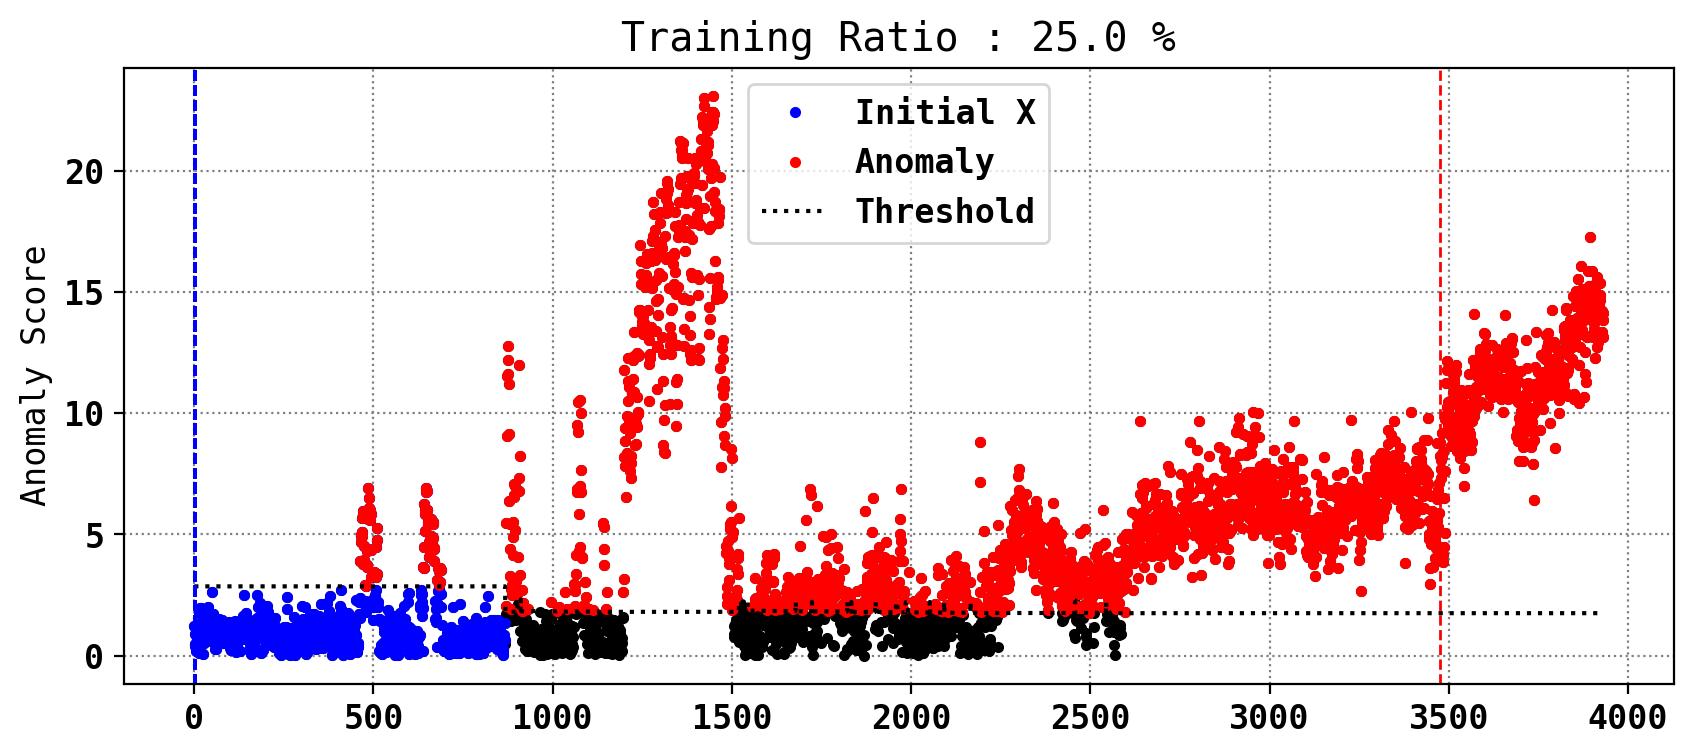

In [24]:
Anomaly_detector.plot_result(f'Training Ratio : {train_ratio * 100} %', df_rawdata['label'], damage_date)